# Exercise with bank marketing data

## Introduction

- Data from the UCI Machine Learning Repository: [data](https://github.com/justmarkham/DAT8/blob/master/data/bank-additional.csv), [data dictionary](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing)
- **Goal:** Predict whether a customer will purchase a bank product marketed over the phone
- `bank-additional.csv` is already in our repo, so there is no need to download the data from the UCI website

## Step 1: Read the data into Pandas

In [3]:
import pandas as pd
url = 'https://raw.githubusercontent.com/justmarkham/DAT8/master/data/bank-additional.csv'
bank = pd.read_csv(url, sep=';')
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


## Step 2: Prepare at least three features

- Include both numeric and categorical features
- Choose features that you think might be related to the response (based on intuition or exploration)
- Think about how to handle missing values (encoded as "unknown")

In [4]:
# list all columns (for reference)
bank.columns

Index([u'age', u'job', u'marital', u'education', u'default', u'housing',
       u'loan', u'contact', u'month', u'day_of_week', u'duration', u'campaign',
       u'pdays', u'previous', u'poutcome', u'emp.var.rate', u'cons.price.idx',
       u'cons.conf.idx', u'euribor3m', u'nr.employed', u'y'],
      dtype='object')

### y (response)

In [8]:
# convert the response to numeric values and store as a new column
bank['outcome'] = bank.y.map({'no':0, 'yes':1})

### age

In [9]:
%matplotlib inline

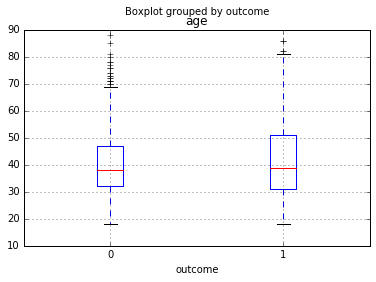

In [10]:
# probably not a great feature
bank.boxplot(column='age', by='outcome')

### job

In [11]:
# looks like a useful feature
bank.groupby('job').outcome.mean()

job
admin.           0.131423
blue-collar      0.069005
entrepreneur     0.054054
housemaid        0.100000
management       0.092593
retired          0.228916
self-employed    0.081761
services         0.089059
student          0.231707
technician       0.115774
unemployed       0.171171
unknown          0.102564
Name: outcome, dtype: float64

In [ ]:
# create job_dummies (we will add it to the bank DataFrame later)
job_dummies = pd.get_dummies(bank.job, prefix='job')
job_dummies.drop(job_dummies.columns[0], axis=1, inplace=True)

### default

In [ ]:
# looks like a useful feature
bank.groupby('default').outcome.mean()

In [ ]:
# but only one person in the dataset has a status of yes
bank.default.value_counts()

In [ ]:
# so, let's treat this as a 2-class feature rather than a 3-class feature
bank['default'] = bank.default.map({'no':0, 'unknown':1, 'yes':1})

### contact

In [ ]:
# looks like a useful feature
bank.groupby('contact').outcome.mean()

In [ ]:
# convert the feature to numeric values
bank['contact'] = bank.contact.map({'cellular':0, 'telephone':1})

### month

In [ ]:
# looks like a useful feature at first glance
bank.groupby('month').outcome.mean()

In [ ]:
# but, it looks like their success rate is actually just correlated with number of calls
# thus, the month feature is unlikely to generalize
bank.groupby('month').outcome.agg(['count', 'mean']).sort('count')

### duration

In [ ]:
# looks like an excellent feature, but you can't know the duration of a call beforehand, thus it can't be used in your model
bank.boxplot(column='duration', by='outcome')

### previous

In [ ]:
# looks like a useful feature
bank.groupby('previous').outcome.mean()

### poutcome

In [ ]:
# looks like a useful feature
bank.groupby('poutcome').outcome.mean()

In [ ]:
# create poutcome_dummies
poutcome_dummies = pd.get_dummies(bank.poutcome, prefix='poutcome')
poutcome_dummies.drop(poutcome_dummies.columns[0], axis=1, inplace=True)

In [ ]:
# concatenate bank DataFrame with job_dummies and poutcome_dummies
bank = pd.concat([bank, job_dummies, poutcome_dummies], axis=1)

### euribor3m

In [ ]:
# looks like an excellent feature
bank.boxplot(column='euribor3m', by='outcome')

## Step 3: Model building

- Use cross-validation to evaluate the AUC of a logistic regression model with your chosen features
- Try to increase the AUC by selecting different sets of features

In [ ]:
# new list of columns (including dummy columns)
bank.columns

In [ ]:
# create X (including 13 dummy columns)
feature_cols = ['default', 'contact', 'previous', 'euribor3m'] + list(bank.columns[-13:])
X = bank[feature_cols]

In [ ]:
# create y
y = bank.outcome

In [ ]:
# calculate cross-validated AUC
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
logreg = LogisticRegression(C=1e9)
cross_val_score(logreg, X, y, cv=10, scoring='roc_auc').mean()

In [ ]:
logreg.coef_